In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import vgg16, VGG16_Weights
import torch.nn.functional as F

class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        # Load the pre-trained VGG16 model and list its features
        # vgg16_features = models.vgg16(pretrained=True).features
        vgg16_features = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

        
        self.conv1 = nn.Sequential(*vgg16_features[:4])  # First conv block
        self.conv2 = nn.Sequential(*vgg16_features[4:9])  # Second conv block
        self.conv3 = nn.Sequential(*vgg16_features[9:16])  # Third conv block
        self.conv4 = nn.Sequential(*vgg16_features[16:23])  # Fourth conv block
        self.conv5 = nn.Sequential(*vgg16_features[23:30])  # Fifth conv block

        # Side output layers
        self.side_output1 = nn.Conv2d(64, 1, kernel_size=1)
        self.side_output2 = nn.Conv2d(128, 1, kernel_size=1)
        self.side_output3 = nn.Conv2d(256, 1, kernel_size=1)
        self.side_output4 = nn.Conv2d(512, 1, kernel_size=1)
        self.side_output5 = nn.Conv2d(512, 1, kernel_size=1)

        # Fusion layer to combine side outputs
        self.fusion = nn.Conv2d(5, 1, kernel_size=1)

    def forward(self, x):
        # Forward pass through each conv block
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        # Side outputs
        so1 = self.side_output1(out1)
        so2 = self.side_output2(out2)
        so3 = self.side_output3(out3)
        so4 = self.side_output4(out4)
        so5 = self.side_output5(out5)

        # Resize side outputs to match the input size
        so1 = F.interpolate(so1, size=x.size()[2:], mode='bilinear', align_corners=False)
        so2 = F.interpolate(so2, size=x.size()[2:], mode='bilinear', align_corners=False)
        so3 = F.interpolate(so3, size=x.size()[2:], mode='bilinear', align_corners=False)
        so4 = F.interpolate(so4, size=x.size()[2:], mode='bilinear', align_corners=False)
        so5 = F.interpolate(so5, size=x.size()[2:], mode='bilinear', align_corners=False)

        # Concatenate side outputs and pass through the fusion layer
        fused = self.fusion(torch.cat((so1, so2, so3, so4, so5), dim=1))

        return fused, so1, so2, so3, so4, so5

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Dataset class with data augmentation
class EdgeDetectionDataset(Dataset):
    def __init__(self, img_dir, gt_dir, transform=None):
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.transform = transform
        self.images = [img for img in os.listdir(img_dir) if img.endswith('.jpg') or img.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        gt_path = os.path.join(self.gt_dir, self.images[idx].replace('.jpg', '.png'))
        image = Image.open(img_path).convert('RGB')
        gt = Image.open(gt_path).convert('L')  # Ground truth in grayscale

        if self.transform:
            seed = torch.random.initial_seed()
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            gt = self.transform(gt)

        return image, gt

# Define transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate dataset, model, loss function, and optimizer
edge_dataset = EdgeDetectionDataset(img_dir='data/BIPED/edges/imgs/train/rgbr/real',
                               gt_dir='data/BIPED/edges/edge_maps/train/rgbr/real',
                               transform=train_transform)
dataloader = DataLoader(edge_dataset, batch_size=4, shuffle=True)


class HEDLoss(nn.Module):
    def __init__(self):
        super(HEDLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, preds, target):
        fused_output, *side_outputs = preds
        loss = self.bce_loss(fused_output, target)
        for side_output in side_outputs:
            loss += self.bce_loss(side_output, target)
        return loss

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def validate(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            running_loss += loss.item()
    return running_loss / len(dataloader)
       
def train(model, train_loader, validation_loader, optimizer, loss_fn, epochs, device):
    early_stopping = EarlyStopping(patience=5, min_delta=0.01)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        # Training phase
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        validation_loss = validate(model, validation_loader, loss_fn, device)
        scheduler.step(validation_loss)  # Adjust learning rate

        # Early Stopping Check
        early_stopping(validation_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Validation Loss: {validation_loss}")

# Assuming everything else is already defined, including dataloaders and model


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizing {device}")
model = HED()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming optimizer is already defined
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

loss_fn = HEDLoss()
torch.cuda.is_available()
from torch.utils.data.dataset import Subset

# Assuming edge_dataset is your complete dataset
num_validation_samples = 50
indices = list(range(len(edge_dataset)))
validation_indices = indices[:num_validation_samples]
train_indices = indices[num_validation_samples:]

train_subset = Subset(edge_dataset, train_indices)
validation_subset = Subset(edge_dataset, validation_indices)

# Create the DataLoaders
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=4, shuffle=False)

train(model, train_loader, validation_loader, optimizer, loss_fn, epochs=100, device=device)


Utilizing cuda


/home/ulixe/Neural-Computation/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 1.6824568510055542, Validation Loss: 1.2269221177467933
Epoch 2, Train Loss: 1.0902517045799054, Validation Loss: 1.0106961589593153
Epoch 3, Train Loss: 0.9418088072224667, Validation Loss: 0.9126133001767672
Epoch 4, Train Loss: 0.8759843989422447, Validation Loss: 0.8732153589908893
Epoch 5, Train Loss: 0.845269431409083, Validation Loss: 0.8558384363467877
Epoch 6, Train Loss: 0.828586630131069, Validation Loss: 0.844866170332982
Epoch 7, Train Loss: 0.8169536935655695, Validation Loss: 0.832285069502317
Epoch 8, Train Loss: 0.8078625806068119, Validation Loss: 0.8240682895366962
Epoch 9, Train Loss: 0.8005124267778898, Validation Loss: 0.8141528276296762
Epoch 10, Train Loss: 0.7963836067601254, Validation Loss: 0.808208167552948
Epoch 11, Train Loss: 0.7890481133210031, Validation Loss: 0.8112475688640888
Epoch 12, Train Loss: 0.7828315002353567, Validation Loss: 0.8103256684083205
Epoch 13, Train Loss: 0.779655762408909, Validation Loss: 0.7995132070321304
E

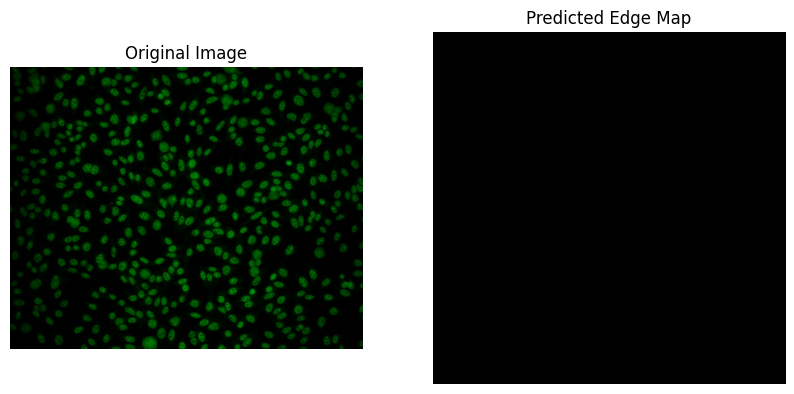

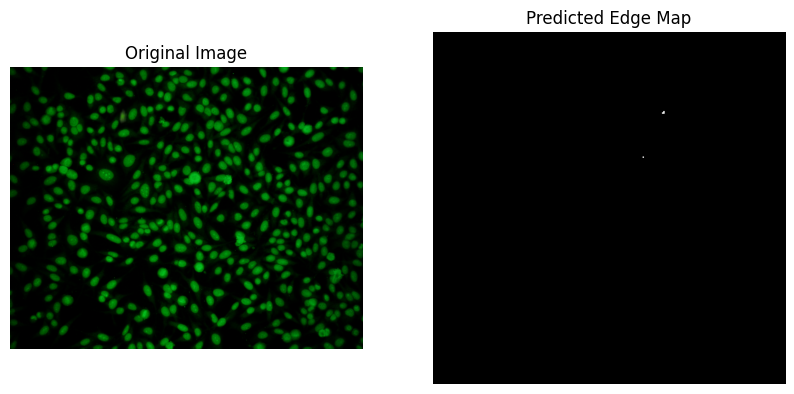

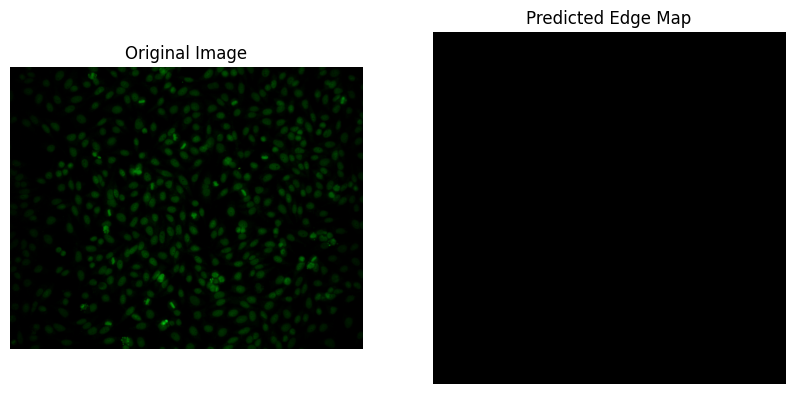

In [6]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming model is your trained HED model

# Load and preprocess an image
def preprocess_image(image_path):
    input_image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to match the training setup
        transforms.ToTensor(),          # Convert to tensor
    ])
    input_tensor = preprocess(input_image)
    # Add a batch dimension (B, C, H, W): model expects a batch of images
    input_batch = input_tensor.unsqueeze(0)  
    return input_batch

# Function to predict edges, with device adjustment
def predict_edges(model, input_batch, device):
    input_batch = input_batch.to(device)  # Move input to the same device as the model
    with torch.no_grad():
        model.eval()
        outputs = model(input_batch)
        fused_output = outputs[0]  # Get the fused output
        probs = torch.sigmoid(fused_output)
        edge_map = probs > 0.25
        return edge_map.squeeze()  # Remove batch dimension for visualization



image_paths = [
    "images/cells/9343 AM.bmp",
    "images/cells/10905 JL.bmp",
    "images/cells/43590 AM.bmp"
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is on the correct device

for image_path in image_paths:
    input_batch = preprocess_image(image_path)
    binary_edge_map = predict_edges(model, input_batch, device)  # Pass device here

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_edge_map.cpu().numpy(), cmap='gray')  # Move tensor back to CPU for visualization
    plt.title('Predicted Edge Map')
    plt.axis('off')

    plt.show()
